In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [24]:
dt = 0.01
D = 1.0
L = 11.0
xl = 5.0
xr = 6.0
N = 100

In [25]:
# generate steps for all particles
steps=np.random.normal(loc=0.0, scale=2*D*dt, size=(N,10000))

In [26]:
# initial positions
x = L*np.random.random(size=(N,))

In [27]:
# put initial position in front
x = np.column_stack((x, steps))

In [28]:
# calculate paths
paths = np.mod(np.cumsum(x, axis=1),L)

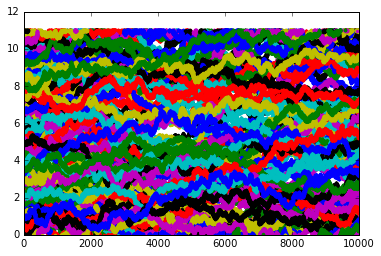

In [29]:
for path in paths:
    plt.plot(path,".")

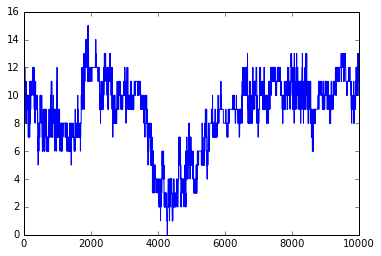

In [30]:
# plot the number of particles in between xl and xr
inbox = np.logical_and(xl<paths,paths<xr)
intensity = np.sum(inbox, axis=0)
plt.plot(intensity)

In [31]:
# place a Gaussian illumination at x=5.5 with unit variance
from scipy.stats import norm
intensity = norm.pdf(paths, loc=5.5)
intensity = np.sum(intensity, axis=0)

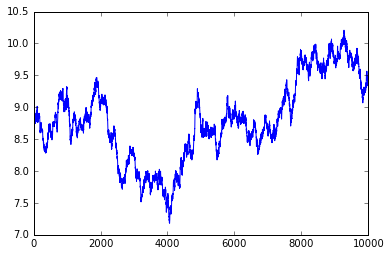

In [32]:
plt.plot(intensity)